
#### $$\texttt{Application of SVD to an Image Classification Problem}$$

## MNIST Dataset

* Dataset is a large collection $(70,000, 28 \times 28 \text{ images)}$ of handwritten digits — 
    * Training set of $60,000$ examples
    * Test set of $10,000$ examples. 
    * Each example is a $28 \times 28$ image, associated with a label from $10$ digits. 
    * Each image is $28$ pixels in height and $28$ pixels in width, for a total of 784 pixels in total. 
    * Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. 
    * This pixel-value is an integer between $0$ and $255$. 

### Importing Libraries for Manipulating and Visualising Data

In [1]:
# pip install keras

In [2]:
# pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
import matplotlib.pyplot as plt
import time

### Loading the MNIST Dataset
* No need to further splitting of data
* Loads in terms of both training and testing data.

In [4]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Number of training samples:", x_train.shape[0])
print("Number of test samples:", x_test.shape[0])
print("Image shape:", x_train[0].shape)
print("Number of classes:", len(np.unique(y_train)))

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Number of training samples: 60000
Number of test samples: 10000
Image shape: (28, 28)
Number of classes: 10


### Visualising the data

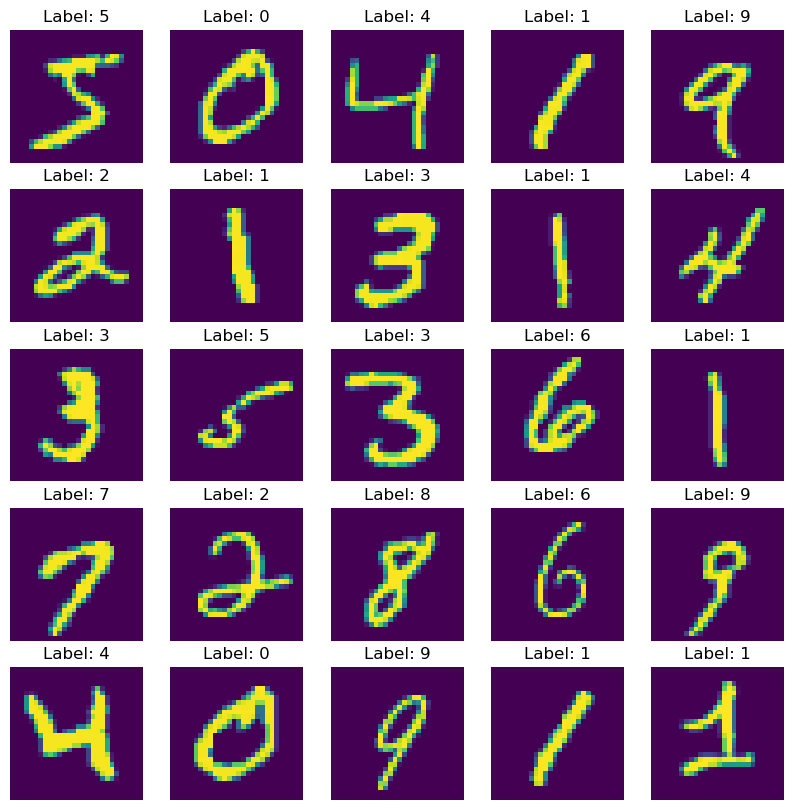

In [6]:
# Display some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title("Label: %s" % y_train[i])
    plt.axis('off')
plt.show()

### Creating Training and Testing Set
* $N = 3000$ images of each digit in the training set is taken to form the digit matrices.
* Used the remaining as (labeled) test images along with $\texttt{y_test}$.

In [7]:
# Number of images considered to train for each digit
N = 3000

# Initialize lists to store images for training and testing for each digit
train_images = []
train_labels = []
test_images = []
test_labels = []

# Initialize counters to keep track of images for each digit
digit_counts = {digit: 0 for digit in range(10)}

# Iterate over each image and its corresponding label
for image, label in zip(x_train, y_train):
    if digit_counts[label] < N:
        train_images.append(image)
        train_labels.append(label)
    else:
        test_images.append(image)
        test_labels.append(label)
    digit_counts[label] += 1

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print the shapes of the arrays
print("Shape of train images array:", train_images.shape)
print("Shape of train labels array:", train_labels.shape)
print("Shape of test images array:", test_images.shape)
print("Shape of test labels array:", test_labels.shape)

Shape of train images array: (30000, 28, 28)
Shape of train labels array: (30000,)
Shape of test images array: (30000, 28, 28)
Shape of test labels array: (30000,)


* Added the remaining images of each digit with the $\texttt{x_test}$ and $\texttt{y_test}$, respectively

In [8]:
x_test = np.concatenate((test_images, x_test))
y_test = np.concatenate((test_labels, y_test))
x_train = train_images
y_train = train_labels

In [9]:
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)
print("Number of training samples:", x_train.shape[0])
print("Number of test samples:", x_test.shape[0])
print("Image shape:", x_train[0].shape)
print("Number of classes:", len(np.unique(y_train)))

Training data shape: (30000, 28, 28)
Test data shape: (40000, 28, 28)
Number of training samples: 30000
Number of test samples: 40000
Image shape: (28, 28)
Number of classes: 10


* First image 28 x 28 matrix and its label

In [10]:
x_train[0].shape, y_train[0]

((28, 28), 5)

### Digit Matrices

* For each digit $i = 0,\dots,9$, a matrix is formed whose columns are images of that digit.
* Each $D(n)$ consists of 784 rows and 3000 columns

In [11]:
# Number of images per digit
N = 3000

# Initialize empty dictionaries to store matrices for each digit
digit_matrices = {}

# Iterate over each digit (0-9)
for digit in range(10):
    # Filter images for the current digit
    digit_indices = np.where( y_train == digit)[0]
    # Random shuffling to get random images
    np.random.shuffle(digit_indices)
    
    # Initialize matrix for the current digit
    digit_matrix = np.zeros((784, N))  # Each image is reshaped to a column vector of size 784
    
    # Populate the matrix with images for the current digit
    for i, idx in enumerate(digit_indices):
        digit_matrix[:, i] = x_train[idx].reshape(-1)  # Reshape image to column vector
    
    # Store the matrix for the current digit
    digit_matrices[digit] = digit_matrix

In [12]:
len(digit_matrices)

10

In [13]:
# Example of accessing the matrix for digit 3
digit_matrices[3].shape

(784, 3000)

* The $10$ matrices formed above are in general not of full rank. 
* For instance, consider the matrix $D(5)$ containing images labeled $5$. The columns span a proper subspace $D(5) \subset \mathbb{R}^{784}$ that would contain all $28 \times 28$ images of $5$. 

In [14]:
print("The Rank of digit matrices")
print("Digit","\t","Rank")
for i in range(10):
    print(i,"\t",np.linalg.matrix_rank(digit_matrices[i]))

The Rank of digit matrices
Digit 	 Rank
0 	 514
1 	 466
2 	 571
3 	 543
4 	 554
5 	 547
6 	 519
7 	 538
8 	 531
9 	 513


### Principal Components
* For each of this matrix $D(n)$, Singular Value Decomposition is performed.
$$D(n) = U_n \Sigma_n V_n^{T} \text{  } \forall \text{ } n = 0, \dots, 9$$
* The first 4 left singular vectors are extracted (i.e., the principal components), which are the first 4 columns of $U_n$
* These are orthonormal basis vectors of the column space of $D(n)$, thus rank of matrix of principal components for each digit is $4$. 


In [15]:
principal_components = {}
# Iterate over each digit (0-9)
for digit in range(10):
    # Perform SVD to extract first 4 left singular vectors (principal components)
    U, S, Vt = np.linalg.svd(digit_matrices[digit], full_matrices=False)
    principal_components[digit] = U[:, :4]  # Extract the first 4 left singular vectors

In [16]:
len(principal_components)

10

In [17]:
principal_components[0].shape

(784, 4)

In [18]:
np.linalg.matrix_rank(principal_components[0])

4

### Original Labelled Images 

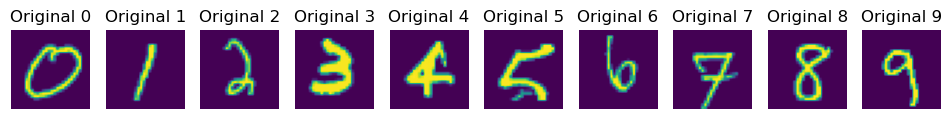

In [19]:
plt.figure(figsize=(12, 10))
for digit in range(10):
    plt.subplot(1, 10, digit + 1)
    # First image from training dataset
    plt.imshow(digit_matrices[digit][:,0].reshape(28,28))
    plt.title("Original "+str(digit))
    plt.axis('off')

### Images generated by Principal Components
* $4$ images of each digit corresponding to left singular vector of the digit matrices, $D(i)$ $\forall$ $i = 0,\dots,9$

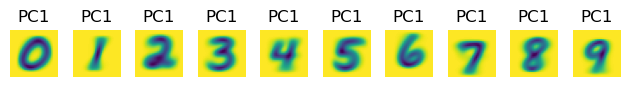

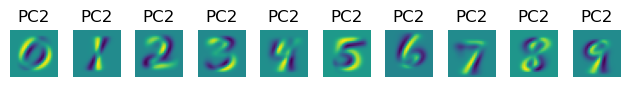

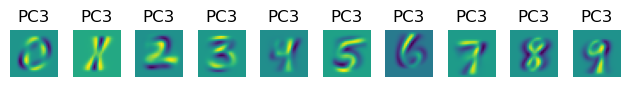

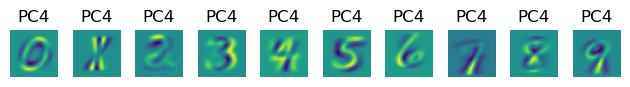

In [20]:
for i in range(4):
# Plot images generated from principal components
    for digit in range(10):
        plt.subplot(5, 10,digit + 1) 
        reconstructed_image = principal_components[digit][:,i].reshape(28,28)
        plt.imshow(reconstructed_image)
        plt.title("PC{}".format(i+1))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

* Now for each digit print the following images are printed
    * The first image are from the training data sets (enough to print the image w.r.t first column of $D(n)$)
    * The four left singular vectors (by reshaping them into 28 × 28 image)
* The final output contains 50 images
    - one original image
    - 4 images corresponding to left singular vector.

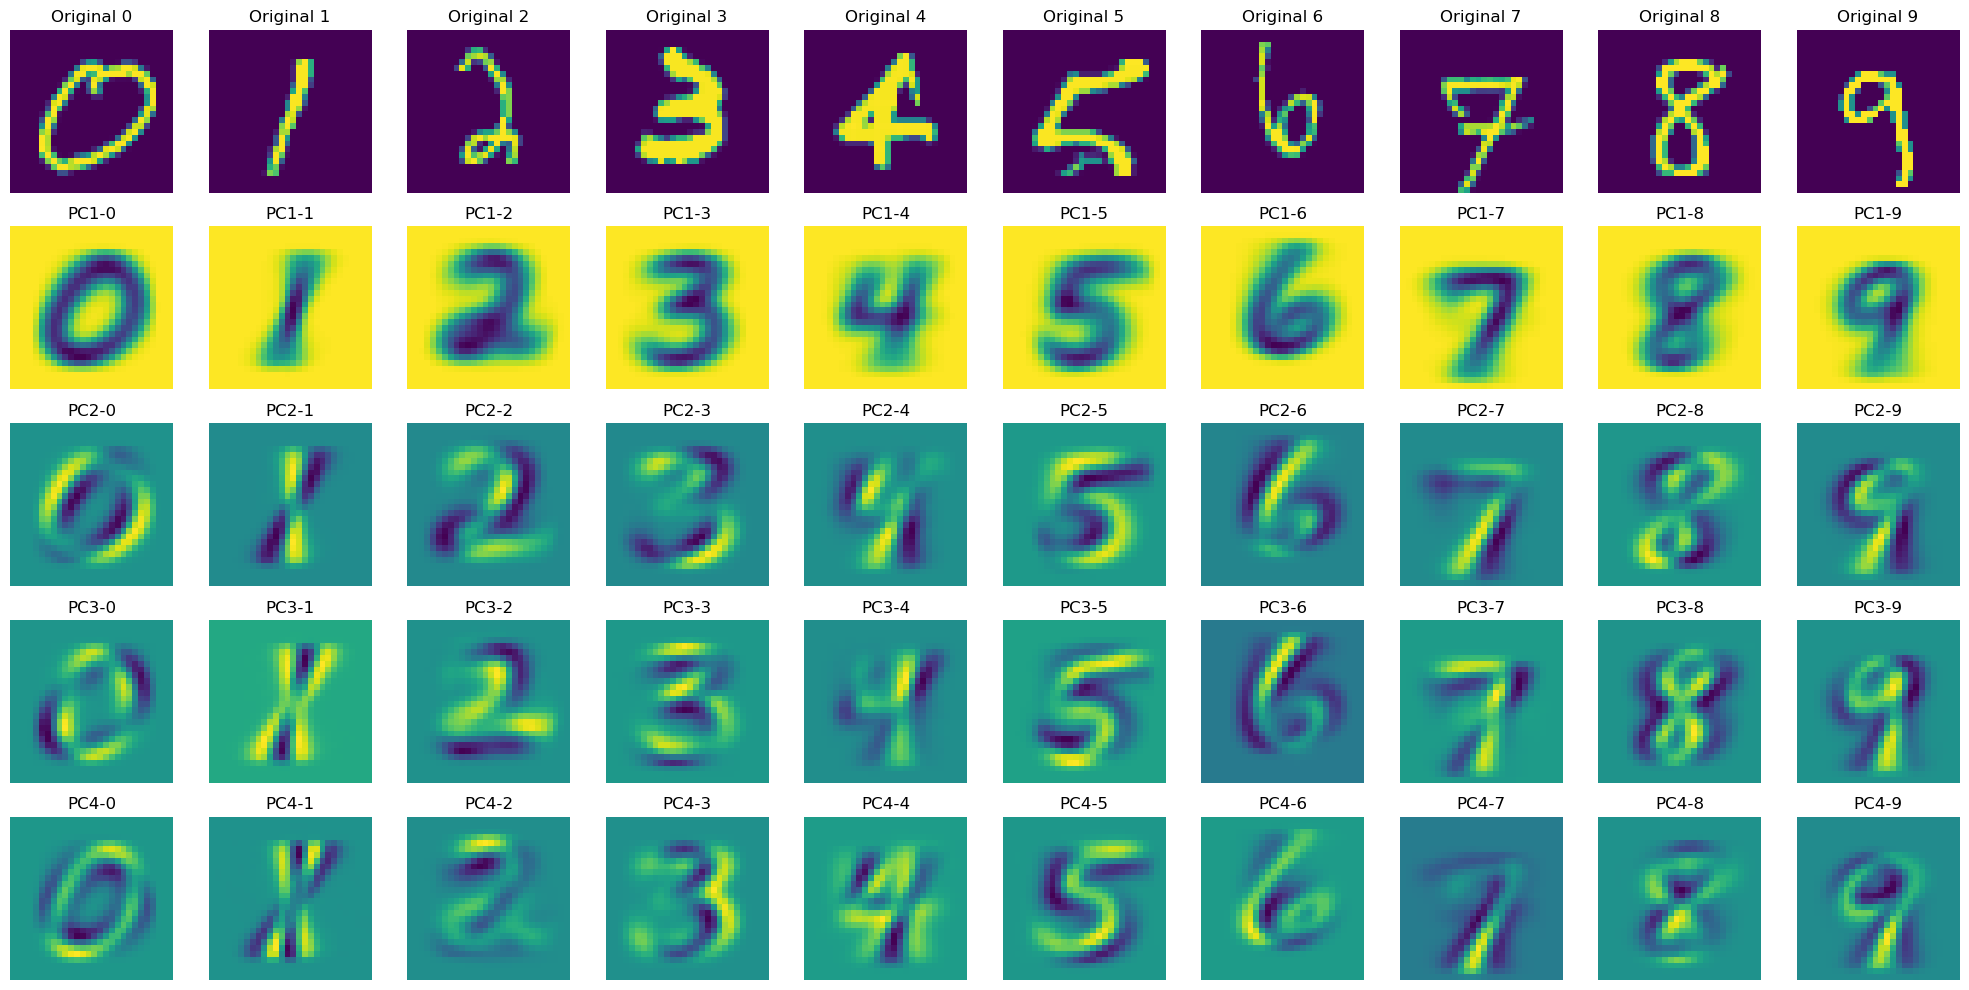

In [21]:
plt.figure(figsize=(20, 10))

# Plot original digits
for digit in range(10):
    plt.subplot(5, 10, digit + 1)
    # First image from training dataset
    plt.imshow(digit_matrices[digit][:, 0].reshape(28, 28))
    plt.title("Original " + str(digit))
    plt.axis('off')

# Plot reconstructed images from principal components
for i in range(4):
    for digit in range(10):
        plt.subplot(5, 10, (i + 1) * 10 + digit + 1) 
        reconstructed_image = principal_components[digit][:, i].reshape(28, 28)
        plt.imshow(reconstructed_image)
        plt.title("PC{}-{}".format(i + 1, digit))
        plt.axis('off')

plt.tight_layout()
plt.show()

### Classification of the test set images

* Given a test image, as a vector $\text{z}$, we would like to compute
$$\rho_n(\text{z}) := \min ||D(n)\text{x} − \text{z}||, \text{ where n is a digit between 0 to 9.}$$
* The value of $n$ for which $\rho_n(\text{z})$ is the least should be the label of $\text{z}$. 
* It is clear that using the full matrix $D_n$ to solve the LSP is ineffecient. This is where SVD enters, where we take 4-rank approximation of the factorization.

In [22]:
digit_matrices[0].shape

(784, 3000)

The $D(n)$ matrix is of order $(m,n)$, where $m = 784 < 3000 = n$. Also, $rank(D(n)) = r < 784$. Thus, it has infinitely many solutions. We want the one with least norm. It can be shown that, by using SVD of $D(n)$, the unique solution to the minimization problem above is, $$\hat{\text{x}} = V_r\Sigma_r^{-1}U_r^{T}{\text{z}} = D(n)^{\dagger}{\text{z}}$$

Now using Low Rank Approximation with $k = 4$ of $\{D(n)|n=0,\dots,9\}$, we want to have "the best 4-dimensional subspace" that our ground truth data would span. For that, the solution to the above minimization problem is given by,
$$\hat{\text{x}} = U_4U_4^{T}{\text{z}}, \text{ where } U_4 = [u_1, u_2, u_2, u_4] \text{ : Principal Component Matrix of digit n (Orthogonal)}$$

In [23]:
# Define function to compute rho_n(z)
def compute_rho(z, digit,principal_components):
    rho_n = np.linalg.norm((principal_components[digit]@principal_components[digit].T)@z - z)
    return rho_n

In [24]:
# Classify test images
def classify_test_images(test_images):
    predicted_labels = []
    for image in test_images:
        min_norm = float('inf')
        predicted_label = None
        for digit in range(10):
            norm_x = compute_rho(image.reshape(-1), digit, principal_components)
            if norm_x < min_norm:
                min_norm = norm_x
                predicted_label = digit
        predicted_labels.append(predicted_label)
    return predicted_labels

### Evaluating Model using Confusion Matrix and Classification Report

1. Fitting the Model
2. Time Taken to fit the model
3. Classification Report
4. Accuracy of the model on test set
5. Confusion Matrix

In [25]:
# Classify test images and time taken to fit
import time
start = time.time()
predicted_labels = classify_test_images(x_test)
end = time.time()
time_taken = end - start

In [26]:
# Time taken to fit the model
print("Time taken to fit the model = {:.2f} secs".format(time_taken))

Time taken to fit the model = 1227.90 secs


* Importing required Machine Learning libraries

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

In [28]:
# Classification Report
classify = classification_report(y_test, predicted_labels)
print("\nClassification Report")
print(classify)


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      3903
           1       0.93      0.99      0.96      4877
           2       0.95      0.90      0.92      3990
           3       0.94      0.89      0.92      4141
           4       0.92      0.90      0.91      3824
           5       0.88      0.89      0.89      3313
           6       0.93      0.95      0.94      3876
           7       0.94      0.89      0.92      4293
           8       0.89      0.88      0.88      3825
           9       0.85      0.89      0.87      3958

    accuracy                           0.92     40000
   macro avg       0.92      0.92      0.92     40000
weighted avg       0.92      0.92      0.92     40000



In [29]:
# Accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.91715


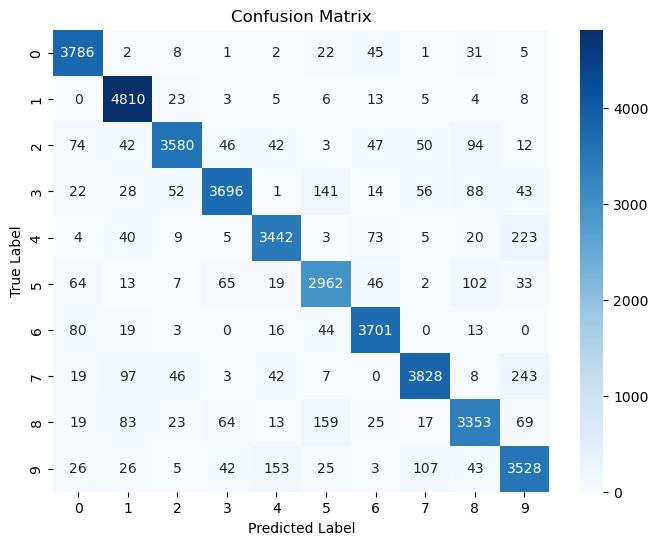

In [30]:
# Confusion Matrix
conf_matrix= confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Concluding Remarks 
* The task is an $\texttt{Image Classification Problem}$ 
* Goal : 
    - **To classify the image of digits 0 to 9**.
* Accuracy is defined as the percentage of correctly classified labels in the test set.
    * Accuracy = <strong>$91.72\%$</strong>